# Infilling the Shell Energy Model

Applying infilling to the Shell energy model, Sky, which contains only CO2 from Energy and Industry. 

You will need to install a silicone version that includes convenience_changes from https://github.com/znicholls/silicone/ in order to run this code. Note that the first runthrough will require collecting large amounts of data and hence will be slow. 

## Imports

In [1]:
import os.path
import traceback
import re

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.multiple_infillers as mi
import silicone.database_crunchers as cr
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    download_or_load_sr15,
    return_cases_which_consistently_split,
    convert_units_to_MtCO2_equiv, 
    
)


<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Our data

Here we will infill the  using the historic RCMIP data.

In [2]:
sr15_file = "./../Input/complete_sr15.csv"
all_models = [
    'AIM/CGE 2.0', 'AIM/CGE 2.1', 'C-ROADS-5.005', 'GCAM 4.2', 'GENeSYS-MOD 1.0', 
    'IEA Energy Technology Perspective Model 2017', 'IEA World Energy Model 2017', 
    'IMAGE 3.0.1', 'IMAGE 3.0.2', 'MERGE-ETL 6.0', 'MESSAGE V.3', 'MESSAGE-GLOBIOM 1.0', 
    'MESSAGEix-GLOBIOM 1.0', 'POLES ADVANCE', 'POLES CD-LINKS', 'POLES EMF33', 'REMIND 1.5', 
    'REMIND 1.7', 'REMIND-MAgPIE 1.5', 'REMIND-MAgPIE 1.7-3.0', 
    'Shell World Energy Model 2018', 'WITCH-GLOBIOM 3.1', 'WITCH-GLOBIOM 4.2', 'WITCH-GLOBIOM 4.4'
]
download_or_load_sr15(sr15_file, all_models)    

# We are only interested in the worldwide record
df = pyam.IamDataFrame(sr15_file).filter(region="World") 
df.head()

pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`
pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`


,model,scenario,region,variable,unit,year,meta,subannual,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,0,0.0,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,0,0.0,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,0,0.0,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,0,0.0,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,0,0.0,5.8486


### Comparing timelines
In order to establish the best infilling method, we should see how it compares to the other available trend lines. We plot the Sky model in black.


In [3]:
model_to_infill = 'Shell World Energy Model 2018'
df_to_infill = df.filter(model=model_to_infill)
lead = ["Emissions|CO2|Energy and Industrial Processes"]

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


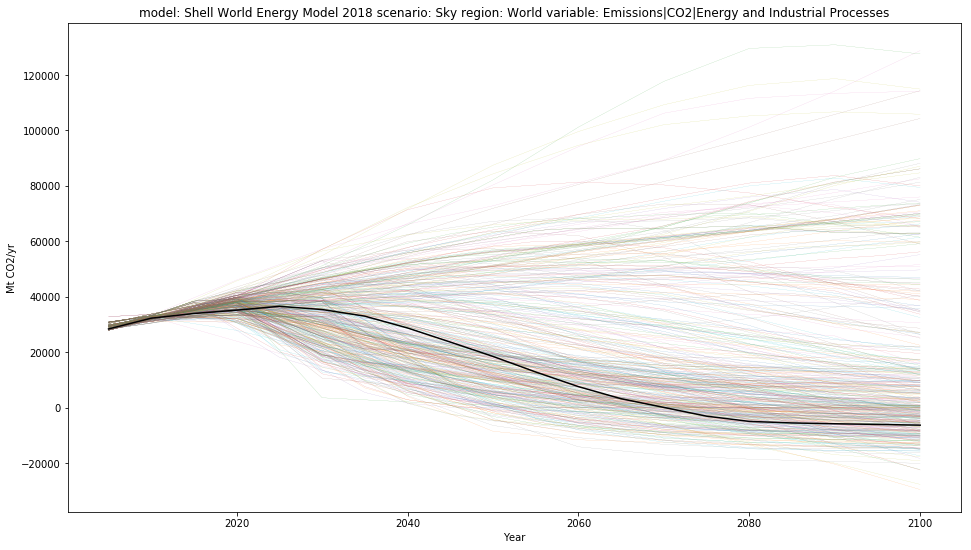

In [4]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
df.filter(variable=lead, year=df_to_infill.data["year"].unique()).line_plot(ax=ax, linewidth=0.1)
df_to_infill.filter(variable=lead).line_plot(ax=ax, color="black")

In [5]:
df_to_infill.data["year"].unique()

array([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
       2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

We see that the CO2 results are well within the expected range. This means we can use an absolute value infilling method. We also see that there are not many paths with a very similar curve. Temporal consistency would point us towards using the RMS closest method, conservatism of the estimate would point towards using the quantile rolling window method. We shall see how the methods vary. 

In [6]:
quantile_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.DatabaseCruncherQuantileRollingWindows,
    output_timesteps=df_to_infill.data["year"].unique(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:165: UserWarning: No data for ['Emissions|HFC|HFC245ca']
  warnings.warn(UserWarning("No data for {}".format(unavailable_variables)))
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:37<00:00,  1.69s/it]


In [7]:
df.filter(variable="Emissions|BC").timeseries().head()

2000  \
model       scenario               region variable     unit     meta subannual         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0         NaN   
            ADVANCE_2020_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0         NaN   
            ADVANCE_2020_WB2C      World  Emissions|BC Mt BC/yr 0.0  0.0         NaN   
            ADVANCE_2030_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0         NaN   
            ADVANCE_2030_Price1.5C World  Emissions|BC Mt BC/yr 0.0  0.0         NaN   

                                                                                  2005  \
model       scenario               region variable     unit     meta subannual           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0        8.3367   
            ADVANCE_2020_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        8.3367   
            ADVANCE_2020_WB2C      World  Emissions|BC Mt BC/yr 0.0  0.0        8.3367   
            ADVANCE_2030_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        8.3367   
            ADVANCE_2030_Price1.5C World  Emissions|BC Mt BC/yr 0.0  0.0        8.3367   

                                                                                  2010  \
model       scenario               region variable     unit     meta subannual           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0        7.6408   
            ADVANCE_2020_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        7.6408   
            ADVANCE_2020_WB2C      World  Emissions|BC Mt BC/yr 0.0  0.0        7.6408   
            ADVANCE_2030_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        7.6408   
            ADVANCE_2030_Price1.5C World  Emissions|BC Mt BC/yr 0.0  0.0        7.6430   

                                                                                  2015  \
model       scenario               region variable     unit     meta subannual           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0        7.2724   
            ADVANCE_2020_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        7.2724   
            ADVANCE_2020_WB2C      World  Emissions|BC Mt BC/yr 0.0  0.0        7.2724   
            ADVANCE_2030_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        7.2724   
            ADVANCE_2030_Price1.5C World  Emissions|BC Mt BC/yr 0.0  0.0        7.2789   

                                                                                  2020  \
model       scenario               region variable     unit     meta subannual           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0        7.0752   
            ADVANCE_2020_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        7.0749   
            ADVANCE_2020_WB2C      World  Emissions|BC Mt BC/yr 0.0  0.0        7.0749   
            ADVANCE_2030_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        7.0693   
            ADVANCE_2030_Price1.5C World  Emissions|BC Mt BC/yr 0.0  0.0        7.0699   

                                                                                  2025  \
model       scenario               region variable     unit     meta subannual           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0        5.8486   
            ADVANCE_2020_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        5.9017   
            ADVANCE_2020_WB2C      World  Emissions|BC Mt BC/yr 0.0  0.0        5.9022   
            ADVANCE_2030_Med2C     World  Emissions|BC Mt BC/yr 0.0  0.0        6.6940   
            ADVANCE_2030_Price1.5C World  Emissions|BC Mt BC/yr 0.0  0.0        6.6819   

                                                                                  2030  \
model       scenario               region variable     unit     meta subannual           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC Mt BC/yr 0.0  0.0        5.2890   
            ADVANCE_2020_Med2C     Wor

In [8]:
infiller_fn = cruncher.derive_relationship(follow, lead)
infilled = infiller_fn(ceds_df)

NameError: name 'cruncher' is not defined

In [ ]:
infilled_ceds = ceds_df.append(infilled)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
infilled_ceds.filter(variable=lead).line_plot(ax=ax)
ax = fig.add_subplot(122)
infilled_ceds.filter(variable=follow).line_plot(ax=ax)
plt.show()